<a href="https://colab.research.google.com/github/jamesafful/classprojects/blob/main/SentAnalysis_2023_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Financial Data

**Afful James** , 490378933

## 1 - Sentiment Analysis Overview

In this Homework, we will be building a machine learning model to detect sentiment (i.e. detect if a sentence is positive, negative, or neutral) using PyTorch.

This will be done on a publicly available Financial Stock Dataset, scrapped from Twitter (now called X).  (Bruno Taborda, Ana de Almeida, José Carlos Dias, Fernando Batista, Ricardo Ribeiro, April 15, 2021, "Stock Market Tweets Data", IEEE Dataport, doi: https://dx.doi.org/10.21227/g8vy-5w61.)

**Introduction**
We'll start out with a recurrent neural network (RNN) as they are commonly used in analysing sequences. An RNN takes in sequence of words,  𝑋=${𝑥_1,...,𝑥_𝑇} $, one at a time, and produces a hidden state,  ℎ , for each word. We use the RNN recurrently by feeding in the current word $x_t$ as well as the hidden state from the previous word,  $ℎ_{𝑡−1}$ , to produce the next hidden state, $h_t$.

$h_t=RNN(x_t,ℎ_{𝑡−1})$

Once we have our final hidden state,  $h_t$ , (from feeding in the last word in the sequence,$x_T$) we feed it through a linear layer, 𝑓 , (also known as a fully connected layer), to receive our predicted sentiment,  𝑦̂=𝑓($ℎ_𝑇$) .
![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment1.png?raw=1)


Note: some layers and steps have been omitted from the diagram. Refer to your classnotes for detailed recap.


The purpose of this homework is to help you familiarize yourself practically with RNNs, understand how they work, and compare the effects of different changes to their system in terms of architecture.


**Homework Outline:**
1. Introduction
2. Import libraries and load the dataset and pre-process data.
3. Build the vocabulary
4. Standard Vanilla RNN with pre-trained word embeddings
3. RNN with LSTM blocks
4. LSTM with regularization
5. Implement either Bidirectional RNN or Multi-layer RNN with regularization
7. Data Augmentation
8. Answer analytical questions about your implementations


The implementation in this homework is inspired by a great tutorial from Ajay Shewale (https://github.com/ajayshewale/Sentiment-Analysis-of-Text-Data-Tweets-/tree/master) and Ben Trevett of Heriot-Watt University in Scotland (https://github.com/bentrevett/pytorch-sentiment-analysis); repurposed and adapted for this class by Samuel Fanijo and Julie Dickerson.

## 2 - Import Library and Load Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

SEED = 123

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Check for GPU, otherwise, use CPU

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### 2.1 - Data Source and Metadata

This dataset is sourced from this work:

Malo, Pekka, et al. "Good debt or bad debt: Detecting semantic orientations in economic texts." Journal of the Association for Information Science and Technology 65.4 (2014): 782-796.


Tweets were collected between April 9 and July 16, 2020 using not only the SPX500 tag but also the top 25 companies in the index and "#stocks". The tweets were manually classified and reviewed.

Dataset has been cleaned and currently has two columns:

- Tweet -> Tweet/text written by the user.
- Sentiment -> Whether the tweet was postive, negative, or neutral.



In [ ]:
#modify path as needed
from google.colab import drive
drive.mount('/content/drive/')
drive_path = "/content/drive/My Drive/"
base_csv = '/content/drive/My Drive/financialdata.csv'

# if in the same directory as your notebook
base_csv = 'financialdata.csv'


df = pd.read_csv(base_csv)
df.head()

Mounted at /content/drive/


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### 3 - Data Preprocessing

### Split dataset to Training and Test

In [ ]:
# Specify the percentage you want for the test set (20% in this case)

test_percentage = 0.2

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=test_percentage, random_state=42)


In [ ]:
train_df

,Sentence,Sentiment
1647,The floor area of the Yliopistonrinne project ...,neutral
1669,"no compensation for its news , opinions or dis...",neutral
3159,RT @ACInvestorBlog $AAPL still on track for $500,positive
4577,This includes a EUR 39.5 mn change in the fair...,neutral
4221,$GTE LONG at 7.44,positive
...,...,...
3772,@BULLYA @pollux654321 My 50 $KORS 80 Calls are...,positive
5191,"According to Sepp+ñnen , the new technology UM...",positive
5226,$CRUS Upgraded to a buy by Alpha Street Research,positive
5390,Favourable currency rates also contributed to ...,positive


In [ ]:
train_df['Sentiment'].value_counts()

neutral     2508
positive    1480
negative     685
Name: Sentiment, dtype: int64

### How balanced is the dataset?

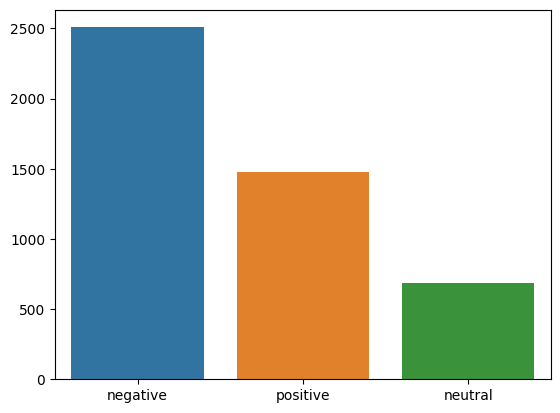

In [ ]:
dd = pd.Series(train_df['Sentiment']).value_counts()
sns.barplot(x=np.array(['negative','positive', 'neutral']),y=dd.values)
plt.show()

### **Note the data imbalance! One of your tasks at the end of this notebook will be to correct this**

### Since the data is small, we can convert them into python lists for further preprocessing

In [ ]:
train_set = list(train_df.to_records(index=False))
test_set = list(test_df.to_records(index=False))

In [ ]:
train_set[:10]

[("The floor area of the Yliopistonrinne project will be 7,900 sq m 85,030 sq ft and the building 's gross area will total 12,800 sq m. A total 25.1 % of the facilities have been let .", 'neutral'),
 ('no compensation for its news , opinions or distributions .', 'neutral'),
 ('RT @ACInvestorBlog $AAPL still on track for $500', 'positive'),
 ('This includes a EUR 39.5 mn change in the fair value of investment properties .', 'neutral'),
 ('$GTE LONG at 7.44', 'positive'),
 ('Product coverage : baked goods ; biscuits ; breakfast cereals Data coverage : market sizes historic and forecasts , company shares , brand shares and distribution data .', 'neutral'),
 ('The investment will be worth approximately EUR 100mn .', 'neutral'),
 ('Typical end-uses include roof structures , floorings , walls and ceilings , non-visible structures in vehicles , packaging and boxes , construction site structures , fencing and shelters , and formwork with a limited number of concrete pourings .', 'neutral'),
 (

### 2.2 Pre-process the data
Since tweets include things such as hyperlinks, numbers, symbols, we need to clean up the data before processing.

In [ ]:
def remove_links(tweet):
    link_pattern = "https?:\/\/t.co/[\w]+"
    mention_pattern = "@\w+"
    tweet = re.sub(link_pattern, "", tweet)
    tweet = re.sub(mention_pattern, "", tweet)
    return tweet.lower()

In [ ]:
remove_links('...Testing link removal...@isucpre @isuNews. https://t.co/isunews')

'...testing link removal... . '

### Tokenization

Using word_tokenize() from the NLTK library, we can split the sentence into tokens, or words, punctuation points, and other language blocks.

In [ ]:
train_set = [(word_tokenize(remove_links(tweet)), label) for tweet, label in train_set]
train_set[:3]

test_set = [(word_tokenize(remove_links(tweet)), label) for tweet, label in test_set]
test_set[:3]

[(['a',
   'few',
   'employees',
   'would',
   'remain',
   'at',
   'the',
   'oulu',
   'plant',
   'in',
   'support',
   'functions',
   'for',
   'other',
   'group',
   'units',
   '.'],
  'neutral'),
 (['comparable',
   'net',
   'sales',
   'are',
   'expected',
   'to',
   'increase',
   'more',
   'than',
   '10',
   '%',
   'in',
   '2008',
   ',',
   'in',
   'line',
   'with',
   'group',
   'target',
   '.'],
  'positive'),
 (['tesla',
   'is',
   'recalling',
   '2,700',
   'model',
   'x',
   'cars',
   ':',
   '$',
   'tsla'],
  'negative')]

## 3 - Building a Vocabulary of Corpus

### 3.1 Vocabulary
Next, we have to build a _vocabulary_. This is a effectively a look up table where every unique word in your data set has a corresponding _index_ (an integer). A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by $V$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment5.png?raw=1)

In this exercise, we will create a list of unique words and use that list and its indices to create a dictionary of mapping.

The list will start with the 3 tokens "PAD", "SOS", "EOS".

Since we will input fixed-size text to the model, we will have to pad some tweets to increase their length. The token for padding is "PAD".

"SOS" and "EOS" are short for "start of sentence" and "end of sentence" respectively. They are tokens used to identify the beginning and ending of each sentence in order to train the model. As will be showm, they will be inserted at the beginning and end of every tweet.

### **index2word** and **word2index** will act as our vocabulary which can be used to encode all tweets

In [ ]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [train_set, test_set]:
    for tweet, label in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [ ]:
index2word[5]

'area'

In [ ]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [ ]:
word2index["area"]

5

### 3.2 Encode tweet and labels

We cannot leave the labels in text form. So, we must encode them using 0 (negative), 1 (neutral), and 2 (positive) respectively.

To pad, we must select a sequence length. This length should cover the majority of tweets.

In [ ]:
def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else: #positive
        return 2

Twitter currently limits tweets to 280 characters, which is up to 40-70 words. However, the average tweet length per user is 28 character, which is up to 10 words.

With that in mind, we will choose 40 as our average sequence length

In [ ]:
seq_length = 40

Padding is performed when a tweet is shorter than 40 tokens, and truncating is used when a tweet is longer than 40 tokens. In the same encoding method, we also insert the PAD, SOS, and EOS tokens.

In [ ]:
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [ ]:
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for tweet, label in train_set]

In [ ]:
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for tweet, label in test_set]

In [ ]:
for i in train_encoded[:5]:
    print(i)

([1, 3, 4, 5, 6, 3, 7, 8, 9, 10, 11, 12, 13, 14, 12, 15, 16, 3, 17, 18, 19, 5, 9, 20, 21, 12, 22, 23, 20, 24, 25, 6, 3, 26, 27, 28, 29, 30, 2, 0], 1)
([1, 31, 32, 33, 34, 35, 36, 37, 38, 39, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 40, 41, 42, 43, 44, 45, 33, 41, 46, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 47, 48, 23, 49, 50, 51, 52, 53, 3, 54, 55, 6, 56, 57, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 41, 58, 59, 60, 61, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)


Notice that the tweets always begin with 1, which stands for SOS, and end with 2, which is EOS. If the tweet is shorter than 40 tokens, it is then padded with 0's, which is the padding. Also, notice that the labels are numerical as well.

Now, the data is preprocessed and encoded, we can go ahead and create PyTorch Datasets and DataLoaders

### 3.3 - Creat PyTorch Dataloaders

In [ ]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

## 4 Vanilla RNN Architecture
The three layers of the Vanilla RNN are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.

The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space. The RNN layer is our RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, $h_t$. Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)

The `forward` method is called when we feed examples into our model.

Each batch, `text`, is a tensor of size _**[sentence length, batch size]**_. That is a batch of sentences, each having each word converted into a one-hot vector.

You may notice that this tensor should have another dimension due to the one-hot vectors, however PyTorch conveniently stores a one-hot vector as it's index value, i.e. the tensor representing a sentence is just a tensor of the indexes for each token in that sentence. The act of converting a list of tokens into a list of indexes is commonly called *numericalizing*.

The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. `embedded` is a tensor of size _**[sentence length, batch size, embedding dim]**_. `embedded` is then fed into the RNN. In some frameworks you must feed the initial hidden state, $h_0$, into the RNN, however in PyTorch, if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1.

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

**Note:** To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state.

# 4.1 RNN Model definition

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class VanillaRNN_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings):
        super(VanillaRNN_SentimentAnalysis,self).__init__()

        # Initialize the embedding layer with pre-trained word vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

        # The RNN layer takes in the embedding size and the hidden vector size.
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization.
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the RNN and
        # outputs a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        # The input is transformed to embeddings by passing it to the embedding layer.
        embs = self.embedding(x)

        # The embedded inputs are fed to the RNN alongside the previous hidden state.
        out, hidden = self.rnn(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer.
        out = self.dropout(out)

        # The last hidden state is extracted for classification.
        out = self.fc(out[:, -1, :])

        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize the hidden state.
        return torch.zeros(1, batch_size, 32)


### 4.2 Pretrained Word Embeddings

Instead of having our word embeddings initialized randomly in our Vanilla RNN architecture, they are initialized with pre-trained vectors.

We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"glove.twitter.27B.100d" vectors"`, particularly because they are more useful for our dataset, which is in form of tweets.

 `glove` is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. `27B` indicates these vectors were trained on 27 billion tokens and `100d` indicates these vectors are 100-dimensional.

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

Note: the embedding files tend to be large and they take awhile to download the first time through. I suggest only running this cell once.

In [ ]:
#!pip3 install torchtext

In [ ]:
import torchtext
import torchtext.vocab as vocab

# Download GloVe embeddings
#glove = vocab.GloVe(name='twitter.27B', dim=100)  # 100-dimensional embeddings

vocab_size = len(word2index)
embedding_dim = 100  # Match the dimension of the GloVe embeddings
hidden_dim = 32
dropout = 0.45  # Adjust dropout as needed

# Create the embedding matrix with pre-trained word vectors
pretrained_embeddings = torch.FloatTensor(vocab_size, embedding_dim)
for word, index in word2index.items():
    if word in glove.stoi:
        pretrained_embeddings[index] = glove.vectors[glove.stoi[word]]
    else:
        pretrained_embeddings[index] = torch.zeros(embedding_dim)  # Use zeros for OOV words

.vector_cache/glove.twitter.27B.zip: 1.52GB [05:24, 4.68MB/s]                            
100%|█████████▉| 1193513/1193514 [01:19<00:00, 15080.29it/s]


### 4.3
Utility Routines for running the models
*count_parameters* a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

*epoch_time* is a function to tell us how long an epoch takes to compare training times between models.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 4.4 Train Vanilla RNN Model

In [ ]:
# Instantiate model with pre-trained embeddings
model1 = VanillaRNN_SentimentAnalysis(vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings)

model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 3e-4)

In [ ]:
print(f'The model has {count_parameters(model1):,} trainable parameters')

The model has 4,387 trainable parameters


Epoch [1/100] | Epoch Time: 0m 1s -- Loss: 1.0155 - Accuracy: 53.20%
Epoch [2/100] | Epoch Time: 0m 0s -- Loss: 0.9868 - Accuracy: 53.61%
Epoch [3/100] | Epoch Time: 0m 0s -- Loss: 0.9845 - Accuracy: 53.59%
Epoch [4/100] | Epoch Time: 0m 0s -- Loss: 0.9828 - Accuracy: 53.63%
Epoch [5/100] | Epoch Time: 0m 0s -- Loss: 0.9840 - Accuracy: 53.74%
Epoch [6/100] | Epoch Time: 0m 0s -- Loss: 0.9835 - Accuracy: 53.59%
Epoch [7/100] | Epoch Time: 0m 0s -- Loss: 0.9808 - Accuracy: 53.81%
Epoch [8/100] | Epoch Time: 0m 0s -- Loss: 0.9827 - Accuracy: 53.76%
Epoch [9/100] | Epoch Time: 0m 1s -- Loss: 0.9817 - Accuracy: 53.76%
Epoch [10/100] | Epoch Time: 0m 1s -- Loss: 0.9790 - Accuracy: 53.94%
Epoch [11/100] | Epoch Time: 0m 1s -- Loss: 0.9764 - Accuracy: 53.96%
Epoch [12/100] | Epoch Time: 0m 1s -- Loss: 0.9785 - Accuracy: 53.89%
Epoch [13/100] | Epoch Time: 0m 0s -- Loss: 0.9774 - Accuracy: 53.81%
Epoch [14/100] | Epoch Time: 0m 0s -- Loss: 0.9783 - Accuracy: 53.81%
Epoch [15/100] | Epoch Time: 

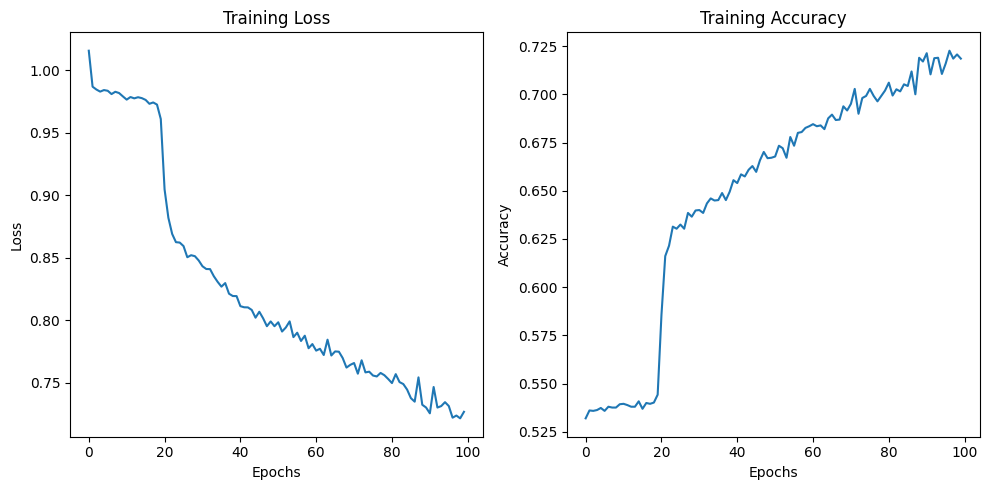

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

epochs = 100
losses = []
accuracies = []

for e in range(epochs):
    batch_size = 50
    h0 = model1.init_hidden(batch_size)
    h0 = h0.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):

            out, hidden = model1(input, h0)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losses.append(total_loss / (batch_idx + 1))
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Print progress after each epoch
    print(f'Epoch [{e + 1}/{epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s -- Loss: {losses[-1]:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

### 4.5 Test Vanilla RNN Model

In [ ]:
# Initialize variables to track test accuracy and loss
test_loss = 0
correct_predictions = 0
total_samples = 0

# Set the model in evaluation mode
model1.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        # Forward pass
        out, hidden = model1(input, h0)

        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples

# Calculate average test loss
average_test_loss = test_loss / (batch_idx + 1)

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Set the model back to training mode if you plan to continue training
model1.train()

Test Accuracy: 64.35%


VanillaRNN_SentimentAnalysis(
  (embedding): Embedding(12991, 100)
  (rnn): RNN(100, 32, batch_first=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

## 5 - LSTM RNN Architectures

We will now use an RNN based on Long Short-Term Memory (LSTM) modules. Recall, standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory.

Thus, the model using an LSTM looks something like (with the embedding layers omitted):

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment2.png?raw=1)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### 5.1 Implementation Details

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state.

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM.

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to.

In [ ]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab
import numpy as np

class LSTM_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings):
        super(LSTM_SentimentAnalysis,self).__init__()

        # Initialize the embedding layer with pre-trained word vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

        # The RNN layer takes in the embedding size and the hidden vector size.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization.
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the RNN and
        # outputs a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden

    def init_hidden(self,batch_size):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))



# Initialize model with pre-trained embeddings
model2 = LSTM_SentimentAnalysis(vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings)


### Train LSTM Model

In [ ]:
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 3e-4)

In [ ]:
print(f'The model has {count_parameters(model2):,} trainable parameters')

The model has 17,251 trainable parameters


Epoch [1/100] | Epoch Time: 0m 1s -- Loss: 1.0657 - Accuracy: 52.41%
Epoch [2/100] | Epoch Time: 0m 1s -- Loss: 1.0016 - Accuracy: 53.66%
Epoch [3/100] | Epoch Time: 0m 1s -- Loss: 0.9805 - Accuracy: 53.81%
Epoch [4/100] | Epoch Time: 0m 2s -- Loss: 0.9789 - Accuracy: 53.70%
Epoch [5/100] | Epoch Time: 0m 1s -- Loss: 0.9522 - Accuracy: 53.61%
Epoch [6/100] | Epoch Time: 0m 1s -- Loss: 0.9105 - Accuracy: 54.06%
Epoch [7/100] | Epoch Time: 0m 1s -- Loss: 0.8829 - Accuracy: 54.73%
Epoch [8/100] | Epoch Time: 0m 1s -- Loss: 0.8699 - Accuracy: 58.71%
Epoch [9/100] | Epoch Time: 0m 1s -- Loss: 0.8498 - Accuracy: 61.29%
Epoch [10/100] | Epoch Time: 0m 1s -- Loss: 0.8426 - Accuracy: 61.89%
Epoch [11/100] | Epoch Time: 0m 1s -- Loss: 0.8264 - Accuracy: 62.71%
Epoch [12/100] | Epoch Time: 0m 1s -- Loss: 0.8178 - Accuracy: 63.46%
Epoch [13/100] | Epoch Time: 0m 1s -- Loss: 0.8063 - Accuracy: 63.87%
Epoch [14/100] | Epoch Time: 0m 1s -- Loss: 0.7997 - Accuracy: 64.15%
Epoch [15/100] | Epoch Time: 

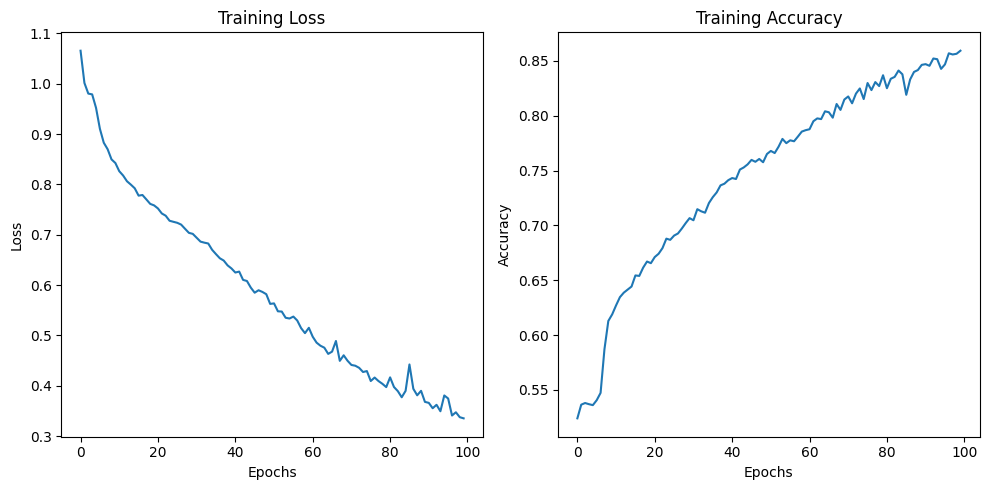

In [ ]:
epochs = 100
losses = []
accuracies = []

for e in range(epochs):
    batch_size = 50
    h0, c0= model2.init_hidden(batch_size)
    h0 = h0.to(device)
    c0 = c0.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model2(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losses.append(total_loss / (batch_idx + 1))
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Print progress after each epoch
    print(f'Epoch [{e + 1}/{epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s -- Loss: {losses[-1]:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

### Test LSTM Model

In [ ]:
# Initialize variables to track test accuracy and loss
test_loss = 0
correct_predictions = 0
total_samples = 0

# Set the model in evaluation mode
model2.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        # Forward pass
        out, hidden = model2(input, (h0, c0))

        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples

# Calculate average test loss
average_test_loss = test_loss / (batch_idx + 1)

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Set the model back to training mode if you plan to continue training
model2.train()

Test Accuracy: 68.96%


LSTM_SentimentAnalysis(
  (embedding): Embedding(12991, 100)
  (lstm): LSTM(100, 32, batch_first=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

## 6 - Other RNN Architectures

### 6.1 Bidirectional RNN

A bidirectional RNN is an RNN processing the words in the sentence from the first to the last (a forward RNN) with a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor.

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment3.png?raw=1)

### 6.2 Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment4.png?raw=1)

*********************************
**Implementing the Bidirectional RNN**

In [ ]:
import torchtext
import torchtext.vocab as vocab

# Download GloVe embeddings
#glove = vocab.GloVe(name='twitter.27B', dim=100)  # 100-dimensional embeddings

vocab_size = len(word2index)
embedding_dim = 100  # Match the dimension of the GloVe embeddings
hidden_dim = 32
dropout = 0.1  # Adjust dropout as needed

# Create the embedding matrix with pre-trained word vectors
pretrained_embeddings = torch.FloatTensor(vocab_size, embedding_dim)
for word, index in word2index.items():
    if word in glove.stoi:
        pretrained_embeddings[index] = glove.vectors[glove.stoi[word]]
    else:
        pretrained_embeddings[index] = torch.zeros(embedding_dim)  # Use zeros for OOV words


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [ ]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab
import numpy as np

class LSTM_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings):
        super(LSTM_SentimentAnalysis, self).__init__()

        # Initialize the embedding layer with pre-trained word vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

        # Modify the LSTM layer to be bidirectional
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Update the dropout
        self.dropout = nn.Dropout(dropout)

        # Update the fully-connected layer to take the concatenated hidden states
        self.fc = nn.Linear(hidden_dim * 2, 3)  # Multiply by 2 because it's bidirectional

    def forward(self, x, hidden):
        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output
        out = self.dropout(out)

        # We concatenate the final forward and backward hidden states
        out = torch.cat((out[:, -1, :hidden_dim], out[:, 0, hidden_dim:]), dim=1)

        # And feed it to the FC layer to get the final class scores
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with dimensions (num_layers * num_directions, batch_size, hidden_dim)
        return (torch.zeros(2, batch_size, 32), torch.zeros(2, batch_size, 32))  # Multiply by 2 for bidirectionality


# Initialize model with pre-trained embeddings
model2 = LSTM_SentimentAnalysis(vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings)


In [ ]:
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 3e-4)

print(f'The model has {count_parameters(model2):,} trainable parameters')

The model has 34,499 trainable parameters


Epoch [1/70] | Epoch Time: 0m 2s -- Loss: 1.0332 - Accuracy: 48.80%
Epoch [2/70] | Epoch Time: 0m 1s -- Loss: 0.9408 - Accuracy: 54.95%
Epoch [3/70] | Epoch Time: 0m 2s -- Loss: 0.8848 - Accuracy: 60.34%
Epoch [4/70] | Epoch Time: 0m 2s -- Loss: 0.8531 - Accuracy: 62.41%
Epoch [5/70] | Epoch Time: 0m 2s -- Loss: 0.8301 - Accuracy: 63.16%
Epoch [6/70] | Epoch Time: 0m 1s -- Loss: 0.8075 - Accuracy: 64.39%
Epoch [7/70] | Epoch Time: 0m 1s -- Loss: 0.7840 - Accuracy: 65.29%
Epoch [8/70] | Epoch Time: 0m 1s -- Loss: 0.7621 - Accuracy: 66.02%
Epoch [9/70] | Epoch Time: 0m 1s -- Loss: 0.7417 - Accuracy: 67.59%
Epoch [10/70] | Epoch Time: 0m 2s -- Loss: 0.7225 - Accuracy: 68.13%
Epoch [11/70] | Epoch Time: 0m 2s -- Loss: 0.7104 - Accuracy: 68.39%
Epoch [12/70] | Epoch Time: 0m 1s -- Loss: 0.6889 - Accuracy: 69.48%
Epoch [13/70] | Epoch Time: 0m 1s -- Loss: 0.6718 - Accuracy: 70.49%
Epoch [14/70] | Epoch Time: 0m 1s -- Loss: 0.6561 - Accuracy: 71.27%
Epoch [15/70] | Epoch Time: 0m 1s -- Loss: 

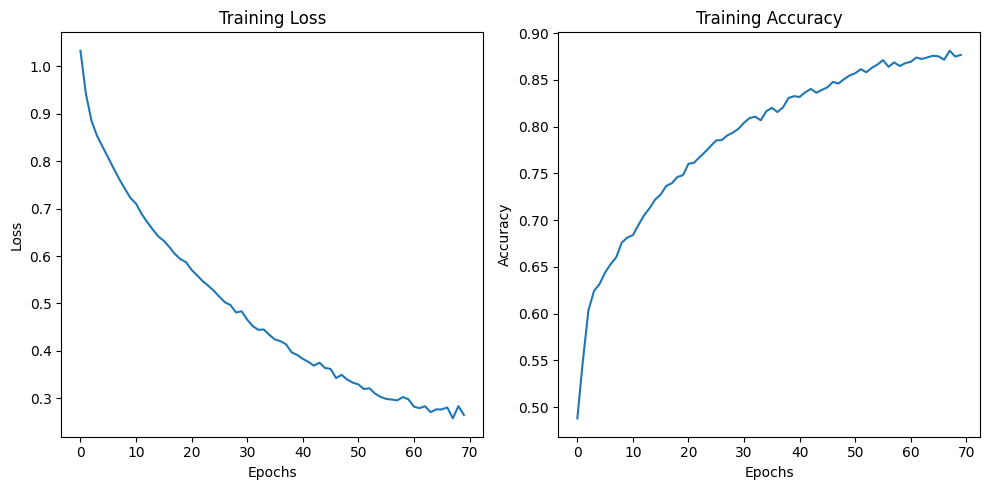

In [ ]:
epochs = 70
losses = []
accuracies = []

for e in range(epochs):
    batch_size = 50
    h0, c0= model2.init_hidden(batch_size)
    h0 = h0.to(device)
    c0 = c0.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model2(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losses.append(total_loss / (batch_idx + 1))
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Print progress after each epoch
    print(f'Epoch [{e + 1}/{epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s -- Loss: {losses[-1]:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to track test accuracy and loss
test_loss = 0
correct_predictions = 0
total_samples = 0

# Set the model in evaluation mode
model2.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        # Forward pass
        out, hidden = model2(input, (h0, c0))

        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples

# Calculate average test loss
average_test_loss = test_loss / (batch_idx + 1)

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Set the model back to training mode if you plan to continue training
model2.train()

Test Accuracy: 68.43%


LSTM_SentimentAnalysis(
  (embedding): Embedding(12991, 100)
  (lstm): LSTM(100, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

********************
**Oversampling**

In [ ]:
from sklearn.utils import resample

# Separate the dataframe by class
df_majority = train_df[train_df.Sentiment == 'neutral']
df_minority_positive = train_df[train_df.Sentiment == 'positive']
df_minority_negative = train_df[train_df.Sentiment == 'negative']

# Upsample minority classes to the size of the majority class
df_minority_positive_upsampled = resample(df_minority_positive,
                                          replace=True,
                                          n_samples=df_majority.shape[0],
                                          random_state=123)

df_minority_negative_upsampled = resample(df_minority_negative,
                                          replace=True,
                                          n_samples=df_majority.shape[0],
                                          random_state=123)

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_positive_upsampled, df_minority_negative_upsampled])

# Shuffle the dataset to prevent the model from learning any order
df_upsampled = df_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)

# Display new class counts
print(df_upsampled.Sentiment.value_counts())


negative    2508
positive    2508
neutral     2508
Name: Sentiment, dtype: int64


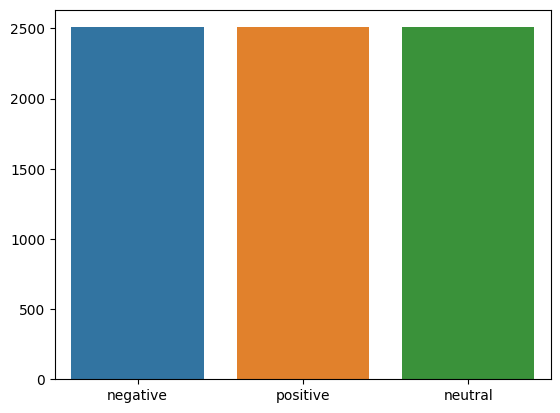

In [ ]:
# Updated code for plotting the distribution after oversampling
dd_upsampled = pd.Series(df_upsampled['Sentiment']).value_counts()
sns.barplot(x=np.array(['negative', 'positive', 'neutral']), y=dd_upsampled.values)
plt.show()


In [ ]:

def remove_links(tweet):
    link_pattern = "https?:\/\/t.co/[\w]+"
    mention_pattern = "@\w+"
    tweet = re.sub(link_pattern, "", tweet)
    tweet = re.sub(mention_pattern, "", tweet)
    return tweet.lower()

remove_links('...Testing link removal...@isucpre @isuNews. https://t.co/isunews')

'...testing link removal... . '

In [ ]:
train_set_balanced = list(df_upsampled.to_records(index=False))

test_set = list(test_df.to_records(index=False))

print(train_set_balanced[:10])



[('Profit before taxes decreased to EUR 31.6 mn from EUR 50.0 mn the year before .', 'negative'), ('The Federal Secretary for Transport and Communication of Mexico has awarded Poyry and its Mexican partner Sintra a consulting contract in connection with the Buenavista-Cuautitlan suburban railway .', 'positive'), ("Capacity of the facility made by Finland 's Vaahto Group is 86,000 tons of light coated paper .", 'neutral'), ("easyJet leads Britain's FTSE lower as global bond rout resumes", 'negative'), ('POYRY PLC Additional information by : Martin Kuzaj , President , Industry Business Group , Finland Tel. +358 10 33 21179 Sanna Paivaniemi , Director , Investor Relations , Poyry PLC , Finland Tel. +358 10 33 23002 Poyry is a global consulting and engineering company dedicated to balanced sustainability .', 'neutral'), ("The platen edges in contact with the band are provided with a seal having a protrusion directed towards the middle area of the platen , and means are provided to exert an

In [ ]:
def remove_links(tweet):
    link_pattern = "https?:\/\/t.co/[\w]+"
    mention_pattern = "@\w+"
    tweet = re.sub(link_pattern, "", tweet)
    tweet = re.sub(mention_pattern, "", tweet)
    return tweet.lower()
remove_links('...Testing link removal...@isucpre @isuNews. https://t.co/isunews')

'...testing link removal... . '

In [ ]:
train_set_balanced = [(word_tokenize(remove_links(tweet)), label) for tweet, label in train_set_balanced]
train_set_balanced[:3]

test_set = [(word_tokenize(remove_links(tweet)), label) for tweet, label in test_set]
test_set[:3]

[(['a',
   'few',
   'employees',
   'would',
   'remain',
   'at',
   'the',
   'oulu',
   'plant',
   'in',
   'support',
   'functions',
   'for',
   'other',
   'group',
   'units',
   '.'],
  'neutral'),
 (['comparable',
   'net',
   'sales',
   'are',
   'expected',
   'to',
   'increase',
   'more',
   'than',
   '10',
   '%',
   'in',
   '2008',
   ',',
   'in',
   'line',
   'with',
   'group',
   'target',
   '.'],
  'positive'),
 (['tesla',
   'is',
   'recalling',
   '2,700',
   'model',
   'x',
   'cars',
   ':',
   '$',
   'tsla'],
  'negative')]

In [ ]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [train_set_balanced, test_set]:
    for tweet, label in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)
index2word[5]

'taxes'

In [ ]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [ ]:
word2index["taxes"]

5

In [ ]:
seq_length = 40

def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for tweet, label in train_set_balanced]

test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for tweet, label in test_set]


for i in train_encoded[:5]:
    print(i)


([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 10, 13, 14, 4, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0)
([1, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 13, 37, 38, 39, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 40, 22, 13, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 22, 51, 52, 53, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 54, 55, 56, 45, 57, 58, 59, 60, 61, 62, 63, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0)
([1, 26, 64, 65, 66, 43, 67, 68, 69, 70, 71, 70, 72, 73, 47, 70, 44, 74, 15, 75, 76, 77, 78, 79, 80, 70, 81, 70, 82, 83, 70, 26, 64, 70, 44, 74, 15, 75, 76, 2], 1)


In [ ]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
import torchtext
import torchtext.vocab as vocab

# Download GloVe embeddings
#glove = vocab.GloVe(name='twitter.27B', dim=100)  # 100-dimensional embeddings

vocab_size = len(word2index)
embedding_dim = 100  # Match the dimension of the GloVe embeddings
hidden_dim = 32
dropout = 0.45  # Adjust dropout as needed

# Create the embedding matrix with pre-trained word vectors
pretrained_embeddings = torch.FloatTensor(vocab_size, embedding_dim)
for word, index in word2index.items():
    if word in glove.stoi:
        pretrained_embeddings[index] = glove.vectors[glove.stoi[word]]
    else:
        pretrained_embeddings[index] = torch.zeros(embedding_dim)  # Use zeros for OOV words

In [ ]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab
import numpy as np

class LSTM_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings):
        super(LSTM_SentimentAnalysis,self).__init__()

        # Initialize the embedding layer with pre-trained word vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

        # The RNN layer takes in the embedding size and the hidden vector size.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization.
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the RNN and
        # outputs a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden

    def init_hidden(self,batch_size):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))



# Initialize model with pre-trained embeddings
model2 = LSTM_SentimentAnalysis(vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings)


In [ ]:
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 3e-4)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model2):,} trainable parameters')

The model has 17,251 trainable parameters


In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch [1/70] | Epoch Time: 0m 1s -- Loss: 1.0993 - Accuracy: 33.40%
Epoch [2/70] | Epoch Time: 0m 2s -- Loss: 1.0983 - Accuracy: 33.28%
Epoch [3/70] | Epoch Time: 0m 2s -- Loss: 1.0963 - Accuracy: 34.69%
Epoch [4/70] | Epoch Time: 0m 2s -- Loss: 1.0937 - Accuracy: 35.01%
Epoch [5/70] | Epoch Time: 0m 1s -- Loss: 1.0543 - Accuracy: 44.27%
Epoch [6/70] | Epoch Time: 0m 1s -- Loss: 1.0086 - Accuracy: 48.95%
Epoch [7/70] | Epoch Time: 0m 1s -- Loss: 0.9754 - Accuracy: 52.40%
Epoch [8/70] | Epoch Time: 0m 1s -- Loss: 0.9495 - Accuracy: 54.01%
Epoch [9/70] | Epoch Time: 0m 2s -- Loss: 0.9333 - Accuracy: 55.37%
Epoch [10/70] | Epoch Time: 0m 2s -- Loss: 0.9202 - Accuracy: 56.20%
Epoch [11/70] | Epoch Time: 0m 2s -- Loss: 0.9068 - Accuracy: 57.17%
Epoch [12/70] | Epoch Time: 0m 1s -- Loss: 0.9000 - Accuracy: 58.04%
Epoch [13/70] | Epoch Time: 0m 1s -- Loss: 0.8797 - Accuracy: 59.28%
Epoch [14/70] | Epoch Time: 0m 1s -- Loss: 0.8691 - Accuracy: 60.60%
Epoch [15/70] | Epoch Time: 0m 1s -- Loss: 

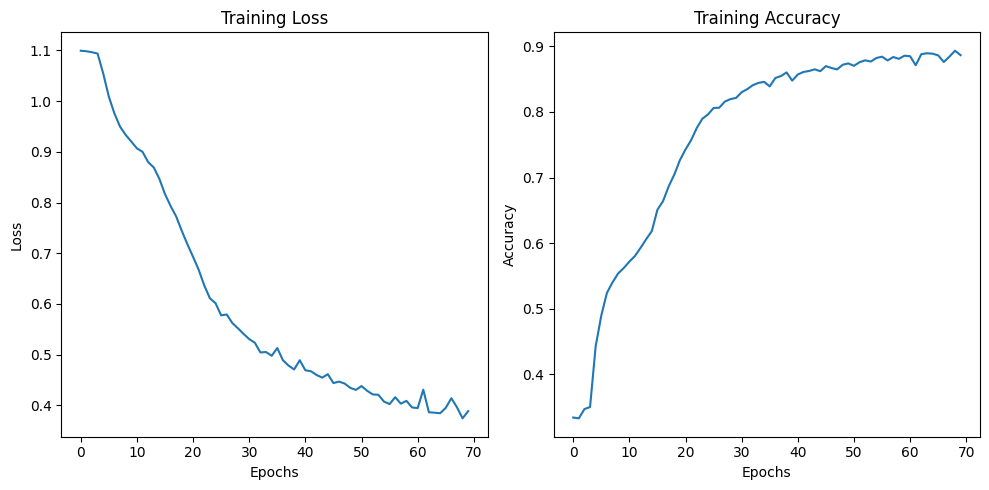

In [ ]:
epochs = 70
losses = []
accuracies = []

for e in range(epochs):
    batch_size = 50
    h0, c0= model2.init_hidden(batch_size)
    h0 = h0.to(device)
    c0 = c0.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model2(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losses.append(total_loss / (batch_idx + 1))
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Print progress after each epoch
    print(f'Epoch [{e + 1}/{epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s -- Loss: {losses[-1]:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to track test accuracy and loss
test_loss = 0
correct_predictions = 0
total_samples = 0

# Set the model in evaluation mode
model2.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        # Forward pass
        out, hidden = model2(input, (h0, c0))

        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples

# Calculate average test loss
average_test_loss = test_loss / (batch_idx + 1)

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Set the model back to training mode if you plan to continue training
model2.train()

Test Accuracy: 67.57%


LSTM_SentimentAnalysis(
  (embedding): Embedding(12608, 100)
  (lstm): LSTM(100, 32, batch_first=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

****************

**Oversampling with Bidirectional LSTM**

In [ ]:
import torchtext
import torchtext.vocab as vocab

# Download GloVe embeddings
#glove = vocab.GloVe(name='twitter.27B', dim=100)  # 100-dimensional embeddings

vocab_size = len(word2index)
embedding_dim = 100  # Match the dimension of the GloVe embeddings
hidden_dim = 32
dropout = 0.25  # Adjust dropout as needed

# Create the embedding matrix with pre-trained word vectors
pretrained_embeddings = torch.FloatTensor(vocab_size, embedding_dim)
for word, index in word2index.items():
    if word in glove.stoi:
        pretrained_embeddings[index] = glove.vectors[glove.stoi[word]]
    else:
        pretrained_embeddings[index] = torch.zeros(embedding_dim)  # Use zeros for OOV words


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [ ]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab
import numpy as np

class LSTM_SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings):
        super(LSTM_SentimentAnalysis, self).__init__()

        # Initialize the embedding layer with pre-trained word vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

        # Modify the LSTM layer to be bidirectional
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Update the dropout
        self.dropout = nn.Dropout(dropout)

        # Update the fully-connected layer to take the concatenated hidden states
        self.fc = nn.Linear(hidden_dim * 2, 3)  # Multiply by 2 because it's bidirectional

    def forward(self, x, hidden):
        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output
        out = self.dropout(out)

        # We concatenate the final forward and backward hidden states
        out = torch.cat((out[:, -1, :hidden_dim], out[:, 0, hidden_dim:]), dim=1)

        # And feed it to the FC layer to get the final class scores
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with dimensions (num_layers * num_directions, batch_size, hidden_dim)
        return (torch.zeros(2, batch_size, 32), torch.zeros(2, batch_size, 32))  # Multiply by 2 for bidirectionality


# Initialize model with pre-trained embeddings
model2 = LSTM_SentimentAnalysis(vocab_size, embedding_dim, hidden_dim, dropout, pretrained_embeddings)


Epoch [1/50] | Epoch Time: 0m 3s -- Loss: 1.1033 - Accuracy: 31.81%
Epoch [2/50] | Epoch Time: 0m 3s -- Loss: 1.1029 - Accuracy: 31.95%
Epoch [3/50] | Epoch Time: 0m 3s -- Loss: 1.1030 - Accuracy: 31.77%
Epoch [4/50] | Epoch Time: 0m 4s -- Loss: 1.1031 - Accuracy: 31.80%
Epoch [5/50] | Epoch Time: 0m 3s -- Loss: 1.1031 - Accuracy: 31.41%
Epoch [6/50] | Epoch Time: 0m 3s -- Loss: 1.1033 - Accuracy: 31.76%
Epoch [7/50] | Epoch Time: 0m 3s -- Loss: 1.1032 - Accuracy: 31.88%
Epoch [8/50] | Epoch Time: 0m 4s -- Loss: 1.1028 - Accuracy: 32.20%
Epoch [9/50] | Epoch Time: 0m 3s -- Loss: 1.1035 - Accuracy: 31.25%
Epoch [10/50] | Epoch Time: 0m 3s -- Loss: 1.1039 - Accuracy: 31.08%
Epoch [11/50] | Epoch Time: 0m 3s -- Loss: 1.1028 - Accuracy: 31.92%
Epoch [12/50] | Epoch Time: 0m 4s -- Loss: 1.1037 - Accuracy: 31.29%
Epoch [13/50] | Epoch Time: 0m 3s -- Loss: 1.1035 - Accuracy: 31.81%
Epoch [14/50] | Epoch Time: 0m 3s -- Loss: 1.1035 - Accuracy: 31.80%
Epoch [15/50] | Epoch Time: 0m 3s -- Loss: 

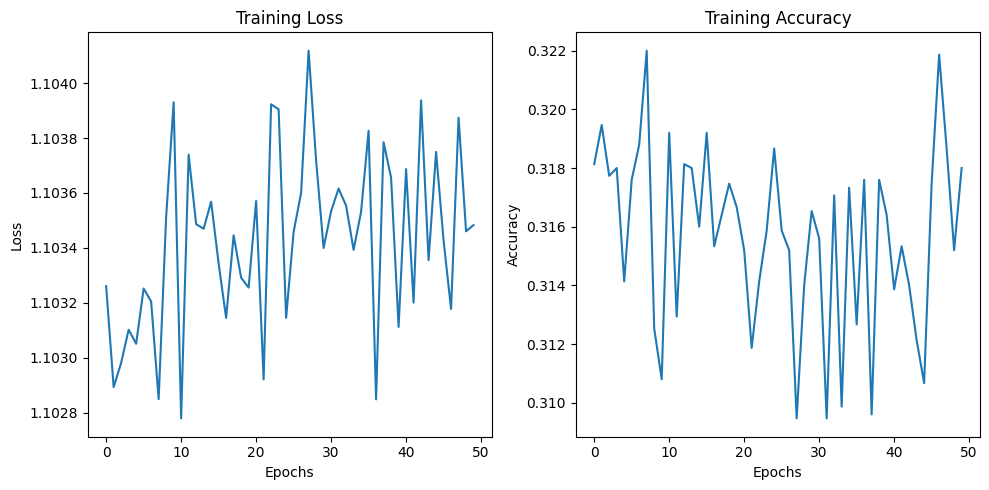

In [ ]:
epochs = 50
losses = []
accuracies = []

for e in range(epochs):
    batch_size = 50
    h0, c0= model2.init_hidden(batch_size)
    h0 = h0.to(device)
    c0 = c0.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model2(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    losses.append(total_loss / (batch_idx + 1))
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Print progress after each epoch
    print(f'Epoch [{e + 1}/{epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s -- Loss: {losses[-1]:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to track test accuracy and loss
test_loss = 0
correct_predictions = 0
total_samples = 0

# Set the model in evaluation mode
model2.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        # Forward pass
        out, hidden = model2(input, (h0, c0))

        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples

# Calculate average test loss
average_test_loss = test_loss / (batch_idx + 1)

# Print test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Set the model back to training mode if you plan to continue training
model2.train()

Test Accuracy: 34.78%


LSTM_SentimentAnalysis(
  (embedding): Embedding(12608, 100)
  (lstm): LSTM(100, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

## 7 Questions to Answer
There are two sets of questions to answer. The first section has to do with the models in the assignment. The second set is on RNN's in genernal.

### 7.1 Working with RNNs for Sentiment Analysis


1. Run the given Vanilla RNN and LSTM Models and analyze the computational cost and accuracy performance

2. Implement at least one of Bi-directional or multi-layer RNN and ensure to improve performance of LSTM model

3. Notice the data imbalance? Implement at least one data augmentation techniques on the dataset, then rerun the LSTM model, and compare performance difference before vs after data augmentation. Pick one of the following augmentation techniques:

  a. Oversampling

  b. Undersampling

  c. Hybrid

### 7.2 RNN Questions


1. Describe the different ways RNNs are used in the applications of named-entity recognition and text synthesis and draw an architecture diagram for each application.

2. Which of the following is true of the weights in a recurrent neural network?
a. The weights are shared between all time steps.
b. The weights are different for each time step.
c. The weights are different for each input.
d. The weights are different for each output.

3. Select the best type of model (CNN, RNN, or Fully connected neural network) for each use case, match the use case to the model and provide a sentence of reasoning.
Use cases:
a. Tumor segmentation analysis or recognizing tumor patches in medical “slides”.
b. Sentiment analysis on a large text corpus.
c. Time series forecasting to predict price of automobile in the next month.
d. Predict the price of a house based on square feet, ratio of bedrooms/bathrooms.
